In [40]:
!pip install sentencepiece

In [42]:
!pip install seaborn

     |████████████████████████████████| 283 kB 5.4 MB/s eta 0:00:01


In [46]:
# importing libraries
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras


import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [467]:
# Read the dataset
import pandas as pd
df = pd.read_csv('DM_Final/winemag-data-130k-v2.csv')

df.head()


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [468]:
# Clean up the data
df = df[['country','description','price','province','title','variety']]
df.head()

,country,description,price,province,title,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",NaN,Sicily & Sardinia,Nicosia 2013 Vulkà Bianco (Etna),White Blend
1,Portugal,"This is ripe and fruity, a wine that is smooth...",15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and...",14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom ...",13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling
4,US,"Much like the regular bottling from 2012, this...",65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir


In [469]:
# Remove points with NaN entries
df = df.dropna()
df

,country,description,price,province,title,variety
1,Portugal,"This is ripe and fruity, a wine that is smooth...",15.0,Douro,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and...",14.0,Oregon,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom ...",13.0,Michigan,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling
4,US,"Much like the regular bottling from 2012, this...",65.0,Oregon,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir
5,Spain,Blackberry and raspberry aromas show a typical...,15.0,Northern Spain,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot
...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,28.0,Mosel,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling
129967,US,Citation is given as much as a decade of bottl...,75.0,Oregon,Citation 2004 Pinot Noir (Oregon),Pinot Noir
129968,France,Well-drained gravel soil gives this wine its c...,30.0,Alsace,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer
129969,France,"A dry style of Pinot Gris, this is crisp with ...",32.0,Alsace,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris


In [470]:
# Get top 5 most popular varieties 
df_variety = df.variety.value_counts()
df_variety.head()

Pinot Noir                  12785
Chardonnay                  11077
Cabernet Sauvignon           9384
Red Blend                    8466
Bordeaux-style Red Blend     5340
Name: variety, dtype: int64

In [471]:
# Get top 5 most popular countires 
df_country = df.country.value_counts()
df_country.head()

US          54265
France      17776
Italy       16914
Spain        6573
Portugal     4875
Name: country, dtype: int64

Text(0.5, 1, 'Country Distribution')

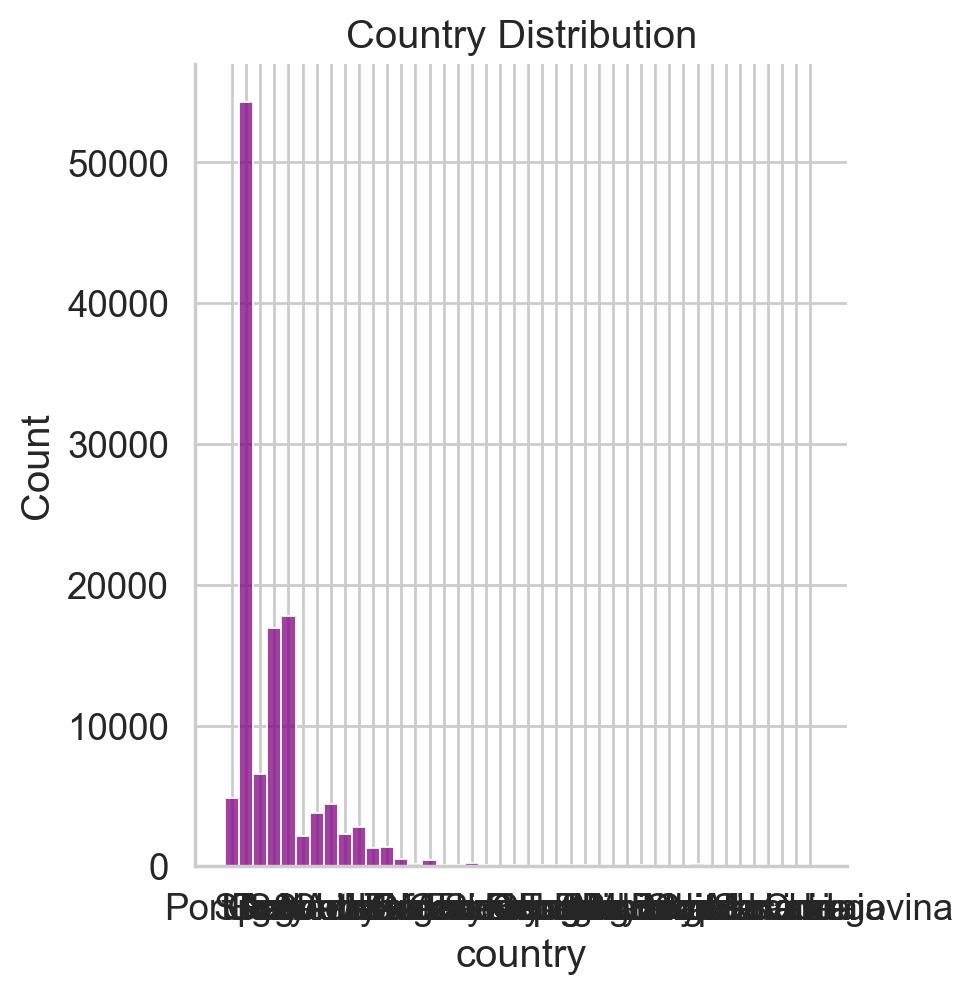

In [472]:
# Country distribution for the entire dataset
# This is not readable -- needs to be fixed
chart = sns.displot(x=df['country'], color = 'purple')
#plt.xlim(0,75)
plt.title("Country Distribution")

In [473]:
# Get top 5 most popular regions 
df_province = df.province.value_counts()
df_province.head()

California    36104
Washington     8583
Oregon         5359
Tuscany        5128
Bordeaux       4002
Name: province, dtype: int64

In [474]:
# Get top 20 most popular price points 
df_price = df.price.value_counts()
df_price.head(20)

20.0    6938
15.0    6066
25.0    5796
30.0    4946
18.0    4881
12.0    3932
40.0    3871
35.0    3801
13.0    3548
16.0    3545
10.0    3439
22.0    3353
50.0    3332
14.0    3214
45.0    3135
17.0    3049
28.0    2938
24.0    2824
19.0    2813
60.0    2277
Name: price, dtype: int64

In [475]:
# Helpful statitics to get a general understanding of price distribution
df['price'].describe()

count    120915.000000
mean         35.368796
std          41.031188
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64

Text(0.5, 1, 'Price Distribution')

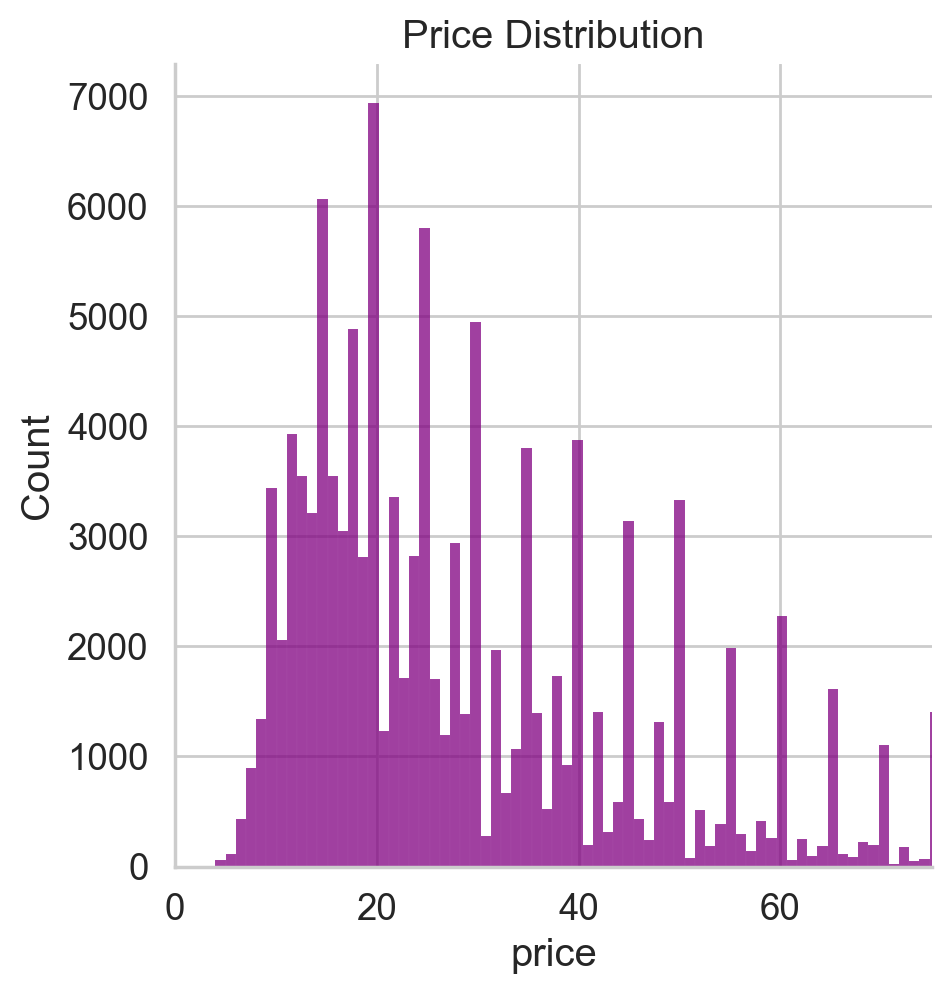

In [476]:
# Price distribution for the entire dataset
chart = sns.displot(x=df['price'], color = 'purple')
plt.xlim(0,75)
plt.title("Price Distribution")

/Users/Nina/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


There are : 0.5640325848736716 % wines more expensive then 200 USD


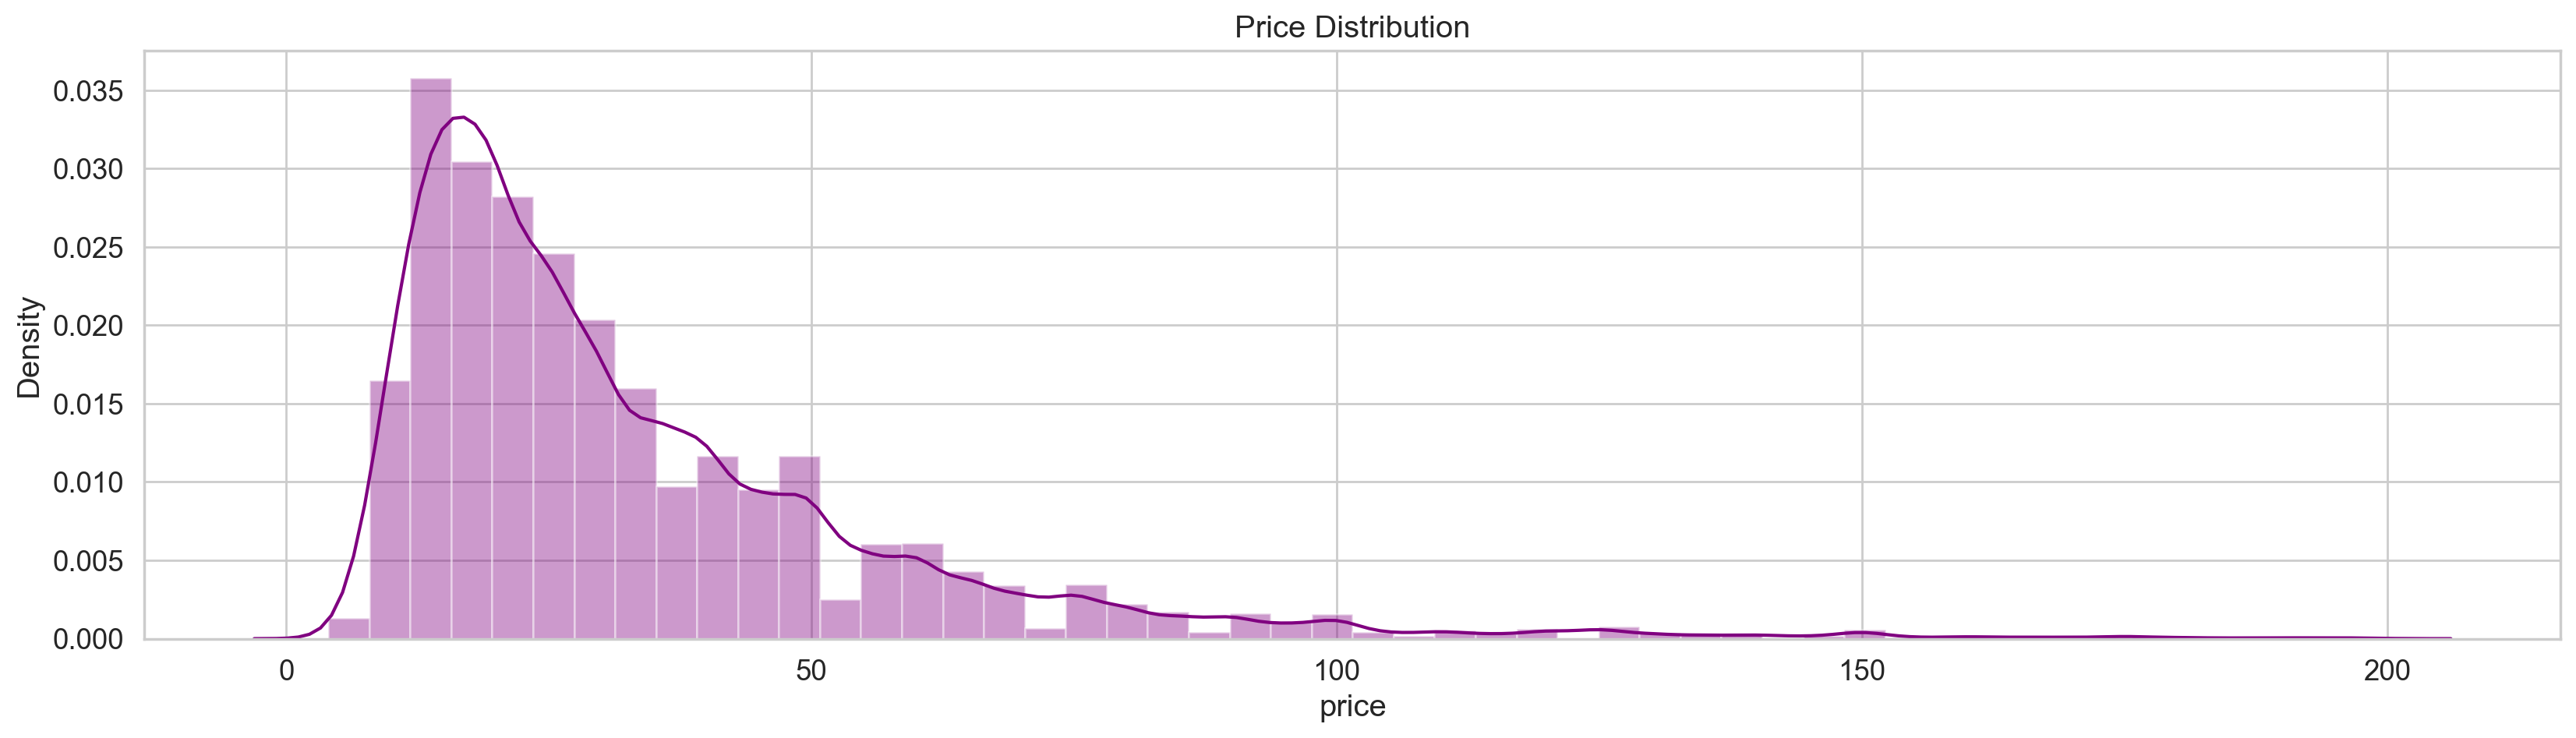

In [477]:
plt.figure(figsize=(20,5))
plt.title("Price Distribution")
chart = sns.distplot(df[df["price"]<200]['price'], color='purple')

percent=df[df['price']>200].shape[0]/df.shape[0]*100
print("There are :", percent, "% wines more expensive then 200 USD")

In [478]:
# Find duplicates
print("Total number of examples: ", df.shape[0])
print("Number of examples with the same title and description: ", df[df.duplicated(['description','title'])].shape[0])

Total number of examples:  120915
Number of examples with the same title and description:  9378


In [442]:
# Remove datapoints with the same title and description
df=df.drop_duplicates(['description','title'])
df=df.reset_index(drop=True)

In [210]:
pip install nltk

     |████████████████████████████████| 1.4 MB 3.0 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434675 sha256=9e52ed181f547795ce6dff44e2b87abea4ccf7c7fa254cf5f769675c5751dc07
  Stored in directory: /Users/Nina/Library/Caches/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk
Note: you may need to restart the kernel to use updated packages.


In [214]:
!pip install wordcloud

     |████████████████████████████████| 220 kB 4.2 MB/s eta 0:00:01
  Created wheel for wordcloud: filename=wordcloud-1.8.1-cp37-cp37m-macosx_10_9_x86_64.whl size=160325 sha256=e3f1240cf6fa6e184860e0b1e27ff0f200b66fba844fab843e69f2415497a2e6
  Stored in directory: /Users/Nina/Library/Caches/pip/wheels/f8/f6/55/6bd394c32a844a621ca0fe5dbf563c8d71d71edaf095656991
Successfully built wordcloud


In [479]:
# NLP
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string

from wordcloud import WordCloud, STOPWORDS
import re

from nltk.tokenize import RegexpTokenizer

In [480]:
# Text preprocessing

# Lowercasing
df['description']= df['description'].str.lower()
df['description']= df['description'].apply(lambda elem: re.sub('[^a-zA-Z]',' ', elem))  
df['description']

1         this is ripe and fruity  a wine that is smooth...
2         tart and snappy  the flavors of lime flesh and...
3         pineapple rind  lemon pith and orange blossom ...
4         much like the regular bottling from       this...
5         blackberry and raspberry aromas show a typical...
                                ...                        
129966    notes of honeysuckle and cantaloupe sweeten th...
129967    citation is given as much as a decade of bottl...
129968    well drained gravel soil gives this wine its c...
129969    a dry style of pinot gris  this is crisp with ...
129970    big  rich and off dry  this is powered by inte...
Name: description, Length: 120915, dtype: object

In [481]:
# Tokenize sentences to list of words since we can't analyze whole sentences
tokenizer = RegexpTokenizer(r'\w+')
words_descriptions = df['description'].apply(tokenizer.tokenize)
words_descriptions.head()

1    [this, is, ripe, and, fruity, a, wine, that, i...
2    [tart, and, snappy, the, flavors, of, lime, fl...
3    [pineapple, rind, lemon, pith, and, orange, bl...
4    [much, like, the, regular, bottling, from, thi...
5    [blackberry, and, raspberry, aromas, show, a, ...
Name: description, dtype: object

In [482]:
# Create a vocabulary
all_words = [word for tokens in words_descriptions for word in tokens]
df['description_lengths']= [len(tokens) for tokens in words_descriptions]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

5005673 words total, with a vocabulary size of 29476


In [483]:
# Check most commonly used words
from collections import Counter
count_all_words = Counter(all_words)
count_all_words.most_common(100)

[('and', 327806),
 ('the', 206361),
 ('a', 167544),
 ('of', 162535),
 ('with', 112581),
 ('this', 106601),
 ('is', 88589),
 ('it', 80419),
 ('wine', 72245),
 ('flavors', 60140),
 ('in', 59556),
 ('to', 52336),
 ('s', 50333),
 ('fruit', 46262),
 ('on', 43764),
 ('aromas', 37466),
 ('that', 37088),
 ('palate', 36786),
 ('finish', 33658),
 ('acidity', 31528),
 ('from', 30161),
 ('but', 29580),
 ('tannins', 28111),
 ('drink', 27953),
 ('cherry', 27830),
 ('black', 27147),
 ('ripe', 24594),
 ('are', 24487),
 ('has', 22066),
 ('for', 20461),
 ('red', 20258),
 ('by', 19068),
 ('notes', 18111),
 ('spice', 17609),
 ('oak', 17332),
 ('an', 16869),
 ('as', 16774),
 ('its', 16394),
 ('nose', 16338),
 ('dry', 16244),
 ('now', 16121),
 ('fresh', 15859),
 ('rich', 15818),
 ('berry', 15785),
 ('full', 14881),
 ('plum', 14282),
 ('apple', 12779),
 ('sweet', 12590),
 ('blend', 12555),
 ('soft', 12488),
 ('well', 12302),
 ('blackberry', 12268),
 ('white', 12019),
 ('light', 11809),
 ('fruits', 11790),
 (

In [224]:
# Download a list of commonly used stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/Nina/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [484]:
# Stopword removal + lemmatization
stopword_list = stopwords.words('english')
ps = PorterStemmer()
words_descriptions = words_descriptions.apply(lambda elem: [word for word in elem if not word in stopword_list])
words_descriptions = words_descriptions.apply(lambda elem: [ps.stem(word) for word in elem])
df['processed_description'] = words_descriptions.apply(lambda elem: ' '.join(elem))

In [485]:
all_words = [word for tokens in words_descriptions for word in tokens]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
count_all_words = Counter(all_words)
count_all_words.most_common(100)

# Deleted around 8k words

3057168 words total, with a vocabulary size of 21063


[('wine', 74818),
 ('flavor', 67751),
 ('fruit', 58454),
 ('finish', 38955),
 ('aroma', 38832),
 ('palat', 36897),
 ('acid', 36226),
 ('cherri', 31998),
 ('drink', 31445),
 ('tannin', 30098),
 ('black', 27176),
 ('ripe', 26216),
 ('dri', 24817),
 ('note', 23895),
 ('spice', 21764),
 ('red', 20490),
 ('rich', 19818),
 ('fresh', 19776),
 ('berri', 17972),
 ('oak', 17914),
 ('show', 17232),
 ('nose', 16354),
 ('plum', 15544),
 ('offer', 15004),
 ('full', 14991),
 ('sweet', 14849),
 ('textur', 14512),
 ('blackberri', 14461),
 ('appl', 14423),
 ('blend', 14412),
 ('bodi', 14270),
 ('balanc', 14086),
 ('soft', 13013),
 ('age', 12619),
 ('crisp', 12479),
 ('well', 12313),
 ('white', 12172),
 ('light', 12147),
 ('dark', 11599),
 ('structur', 11489),
 ('citru', 11016),
 ('raspberri', 10716),
 ('hint', 10655),
 ('vanilla', 10642),
 ('herb', 10636),
 ('cabernet', 10628),
 ('fruiti', 10558),
 ('miner', 10428),
 ('bright', 10272),
 ('give', 10012),
 ('pepper', 9933),
 ('touch', 9714),
 ('lemon', 94

In [493]:
# Check for correctness by looking at 2 random rows of processed dataset
df[['description','processed_description','variety']].sample(2)

,description,processed_description,variety
16505,one of jolivet s single vineyard wines this c...,one jolivet singl vineyard wine come south fac...,Sauvignon Blanc
77080,hibiscus rose juniper clove marjoram and g...,hibiscu rose junip clove marjoram graphit arom...,Pinot Noir


<FreqDist with 21063 samples and 3057168 outcomes>


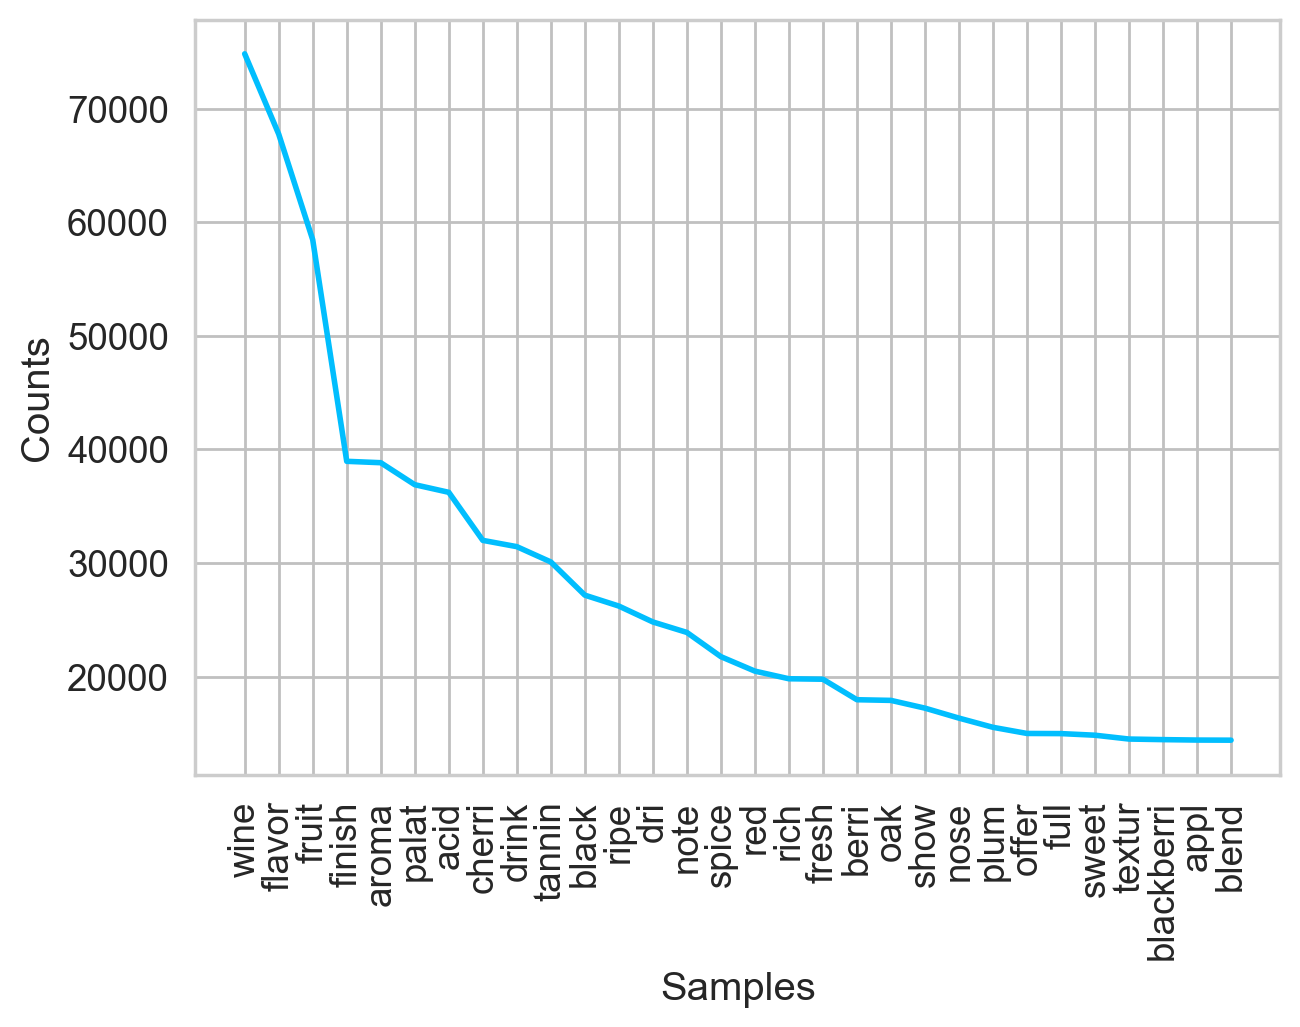

In [487]:
from nltk.probability import FreqDist
fdist = FreqDist(all_words)
print(fdist)
fdist.plot(30,cumulative=False)
plt.show()

In [498]:
# Splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.processed_description, df.variety, test_size = 0.2, random_state = 42)

In [502]:
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)


In [503]:
train_df.head()

,processed_description,variety
27782,special properti bolgheri includ one itali imp...,Red Blend
75483,subbrand chianti classico castello di volpaia ...,Vermentino
120077,nose estat wine emerg slowli enough snif offer...,Chardonnay
24284,good valu wine solid structur nice balanc blac...,Cabernet Sauvignon
55194,select grape concentr wine dens still need age...,Portuguese Red


In [504]:
test_df.head()

,processed_description,variety
119291,exceedingli fresh fragrant medium structur bri...,Pinot Grigio
30959,cheer bright prosecco deliv entic aroma dri ha...,Glera
96773,pretti cranberri light red berri fruit swath d...,Pinot Noir
102381,grenach petit sirah wine quit ripe straightfor...,Zinfandel
129915,third vintag mith best yet compos fruit three ...,Red Blend


In [506]:
# Turn processed text into an array
from sklearn.feature_extraction.text import CountVectorizer
vectorize = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False)
X_train = vectorize.fit_transform(train_df['processed_description'])

#Bow(w, d)= Number of times word w appears in document d

In [508]:
X_test = vectorize.transform(test_df['processed_description'])

In [509]:
# Logistic regression
from sklearn.linear_model import LogisticRegression

def simple_logistic_classify(X_train, y_train, X_test, y_test, _C=1.0):
    # Initialize and fit the model
    model = LogisticRegression(C=_C).fit(X_train, y_train)
    y_pred=model.predict(X_test)
    score = model.score(X_test, y_test)
    print(y_pred)
    print('Test Score: ', score)
    return model

In [510]:
simple_logistic_classify(X_train, y_train, X_test, y_test, _C=1.0)

/Users/Nina/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


['Vermentino' 'Glera' 'Pinot Noir' ... 'Bonarda' 'Merlot' 'Pinot Noir']
Test Score:  0.5908282677914237


LogisticRegression()

In [391]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/Nina/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [511]:
# Cleas input string
def clean_text(sentence):
    '''Text Preprocessing '''
    
    # Convert words to lower case
    sentence = sentence.lower()
    
    # Format words and remove unwanted characters
    sentence = re.sub(r'https?:\/\/.*[\r\n]*', '', sentence, flags=re.MULTILINE)
    sentence = re.sub(r'\<a href', ' ', sentence)
    sentence = re.sub(r'&amp;', '', sentence) 
    sentence = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', sentence)
    sentence = re.sub(r'<br />', ' ', sentence)
    sentence = re.sub(r'\'', ' ', sentence)
    
    # remove stopwords
    sentence = sentence.split()
    stops = set(stopwords.words("english"))
    sentence = [w for w in sentence if not w in stops]
    sentence = " ".join(sentence)

    # Tokenize each word
    sentence =  nltk.WordPunctTokenizer().tokenize(sentence)

#     # Lemmatize each token
#     lemm = nltk.stem.WordNetLemmatizer()
#     sentence = list(map(lambda word:list(map(lemm.lemmatize, word)), sentence))
    
    return sentence

In [512]:
clean_text("Hi team!")

['hi', 'team']

In [523]:
# Trying it out
def recommend_wine(sentence):
    # Preprocess the input
    sentence = clean_text(sentence)
    
    # Turn processed text into an array
    vectorize = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False)
    array_text = vectorize.fit_transform(sentence)
    Xarray_text = array_text.todense()
    print(y_pred)
#     model = LogisticRegression()
    prediction = LogisticRegression.predict(array_text)
    
#     for text, label in zip(sentence, prediction):
#         print("text:", text, "\nintent:", classes[label])
#         print()

In [524]:
recommend_wine("Strong wine made of red! grapes!")

NameError: name 'y_pred' is not defined